In [ ]:
# Iremos construir esse código usando eager execution. Eager execution foi lançado no TensorFlow em 2018. Quando habilitado, 
# permite que rodemos um código tensorflow sem a necessidade de construir um grafo e rodar uma sessão. Com eager execution, 
# todas as informações que passamos com tensorflow são diretamente retornados pelo Python. 

# Com a eager execution ativada, o Tensorflow irá calcular os valores dos tensores conforme eles aparecem no código. 
# Isso significa que ele não cria um gráfico estático para o qual as entradas são alimentadas. Ou seja,
# para fazer backpropagation de erros, temos que salvar os gradientes calculados e depois aplicá-los a um otimizador. 
# Usando a função GradientTape() com eager execution, podemos salvar todas as etapas do gradiente descendente.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import functools
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

tf.enable_eager_execution() # habilitando eager execution
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [2]:
# Salvando os endereços das imagens:
diretorio_img_conteudo = 'C:/Users/Natanael/Documents/DidaticaTech/Green_Sea_Turtle_grazing_seagrass.jpg'
diretorio_img_estilo = 'C:/Users/Natanael/Documents/DidaticaTech/The_Great_Wave_off_Kanagawa.jpg'

In [3]:
# Essa função abaixo irá carregar a imagem, redimensionar, converter para um array numpy e inserir uma dimensão (batch_size):
def carrega_imagem(diretorio):  
    dimensao_maxima = 512
    imagem = Image.open(diretorio) # abrindo a imagem com Pillow
    maxima_dim_img = max(imagem.size) # pegando a maior dimensão da imagem atual
    escala = dimensao_maxima/maxima_dim_img # dividindo o tamanho definido de 512 pela maior dimensão para criar o fator de escala
    imagem = imagem.resize((round(imagem.size[0]*escala), round(imagem.size[1]*escala)), Image.ANTIALIAS) # reescala a imagem colocando no formato de max_dim=512. Aplica um filtro antialias. 
    # O filtro antialias é para evitar distorções ao redimensionar uma imagem. Ele basicamente remove frequências muito altas da imagem com maior resolução antes criar a imagem de menor resolução. Assim as interpolações ficam mais suaves. Aqui tem um exemplo bom de aplicação em um tabuleiro: https://en.wikipedia.org/wiki/Spatial_anti-aliasing
    imagem = kp_image.img_to_array(imagem) # a função img_to_array() converte uma imagem Pillow em um array numpy
    imagem = np.expand_dims(imagem, axis=0) # aumentando a dimensão (para informar quantas imagens em cada batch)
    return imagem

In [4]:
# Essa função abaixo apenas mostra a imagem na tela:
def mostra_imagem(imagem, titulo=None):
    saida = np.squeeze(imagem, axis=0) # remove a dimensão do bach para poder mostrar na tela
    saida = saida.astype('uint8') # transforma para o type int8
    plt.imshow(saida) # mostra a imagem
    if titulo is not None: 
        plt.title(titulo) # coloca um título, caso informado
    plt.imshow(saida)

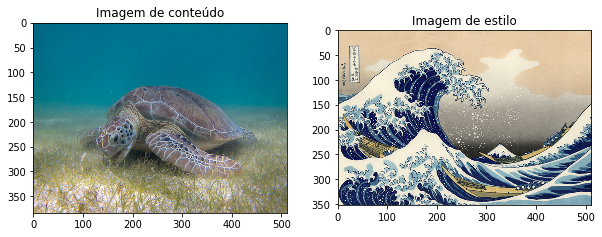

In [5]:
plt.figure(figsize=(10,10))

# Carregando as imagens:
conteudo = carrega_imagem(diretorio_img_conteudo).astype('uint8')
estilo = carrega_imagem(diretorio_img_estilo).astype('uint8')

# Mostrando as imagens
plt.subplot(1, 2, 1) # colocando a imagem de conteúdo no quadrante da esquerda
mostra_imagem(conteudo, 'Imagem de conteúdo')
plt.subplot(1, 2, 2) # colocando a imagem de estilo no quadrante da direita
mostra_imagem(estilo, 'Imagem de estilo')
plt.show()

In [6]:
# Vamos usar a CNN treinada VGG19 (é o sugerido pelo paper)
# Na função abaixo, iremos aplicar o pré-processamento que foi utilizado no treinamento dessa CNN, como subtração pela média, 
# entre outros:
def preprocessamento_vgg19(diretorio):
    imagem = carrega_imagem(diretorio)
    imagem = tf.keras.applications.vgg19.preprocess_input(imagem)
    return imagem

In [7]:
# Para poder visualizar o resultado de nossa imagem gerada, precisaremos executar o inverso do pré-processamento feito acima. 
def inv_preprocess(imagem_preprocessada):
    x = imagem_preprocessada.copy() # copia a imagem passada e salva na variável x
    if len(x.shape) == 4: # se há 4 dimensões
        x = np.squeeze(x, 0) # remove a dimensão do batch_size
    assert len(x.shape) == 3 # verifica se o shape possui dimensão de 3, caso contrário, resulta em uma mensagem de erro
    if len(x.shape) != 3: 
        raise ValueError("Dimensão de entrada inválida para aplicar o inv_preprocess") # define a mensagem de erro
    # Aplicando o inverso do pré-processamento, desfazendo a subtração pela média:
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1] # mantém a largura e a altura da imagem x, mas inverte as posições da profundidade (BGR x RGB)
    x = np.clip(x, 0, 255).astype('uint8') # Define um valor mínimo (0) e um máximo (255) para a saída
    return x

In [8]:
# Escolhendo o layer que servirá para o cálculo da função de custo de conteúdo:
layer_conteudo = ['block5_conv2'] 

# Escolhendo os layers que servirão para o cálculo da função de custo de estilo:
layers_estilo = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']

num_layers_conteudo = len(layer_conteudo)
num_layers_estilo= len(layers_estilo)

In [9]:
# Agora iremos criar uma função que cria o modelo VGG19 e retorna as saídas dos layers que nos interessam: 
def modelo():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet') # carregando o modelo treinado
    # include_top=True inclui as 3 camadas totalmente conectadas no final da rede. Não precisamos delas aqui.
    vgg.trainable = False # informa que não queremos treinar nenhum peso ou bias da rede ao passar o gradiente descendente
    saida_conteudo = [vgg.get_layer(nome).output for nome in layer_conteudo] # capturando os layers específicos de conteúdo
    saidas_estilo = [vgg.get_layer(nome).output for nome in layers_estilo] # capturando os layers específicos de estilo
    saidas_modelo = saidas_estilo + saida_conteudo # salvando todos os layers em uma única variável
    return models.Model(vgg.input, saidas_modelo) # Aqui aplicamos a função Model() do keras para construir o modelo. 
    # A entrada desse modelo que estamos construindo é o vgg19 (por isso passamos vgg.input), e a saída são os layers definidos
    # na variável saidas_modelo. Em outras palavras, estamos criando o modelo vgg19 onde a saída são os layers que nos interessam.

In [10]:
# Criando a função que calcula a diferença dos quadrados para a função de custo de conteúdo:
def custo_conteudo(tensores_conteudo, target):
    return tf.reduce_mean(tf.square(tensores_conteudo - target))
# Obs: iremos passar para essa função os tensores de conteúdo já prontos

In [11]:
# Criando a função que calcula a função de custo de estilo:

def gram_matrix(tensor_entrada): # criando a função Gram Matrix para um tensor específico de 3 dimensões (layer/feature map)
    profundidade = int(tensor_entrada.shape[-1]) # pega o tamanho da profundidade do layer (nº de feature maps do layer)
    entrada_remodelada = tf.reshape(tensor_entrada, [-1, profundidade]) # muda o shape do tensor, transformando as dimensões largura x altura em um 
    # único vetor comprido, e mantém a dimensão da profundidade (para manter as camadas; diferentes feature maps). Então se era
    # um tensor (3, 4, 5), ficará (12, 5).
    num_elementos = tf.shape(entrada_remodelada)[0] # pega o número de elementos que um feature map possui (largura x altura)
    gram = tf.matmul(entrada_remodelada, entrada_remodelada, transpose_a=True) # multiplica-se todo o tensor por ele mesmo 
    # transposto. Se ele era 12x5, teremos 12x5 * 5x12. 
    # Na prática, isso fará com que cada um dos elementos de um feature map seja multiplicado por todos os demais.
    # Teremos como saída uma matriz n x n (onde n é a quantidade de elementos de um feature map)
    return gram / tf.cast(num_elementos, tf.float32) # retorna o valor da matriz normalizado pela quantidade de elementos

def custo_estilo(tensores_estilo, gram_target):
    altura, largura, profundidade = tensores_estilo.get_shape().as_list() # captura as dimensões da imagem de entrada
    gram_estilo = gram_matrix(tensores_estilo) # aplica a função gram_matrix nos tensores de estilo da imagem gerada
    return tf.reduce_mean(tf.square(gram_estilo - gram_target)) # calcula a diferença dos quadrados entre as gram_matrix
    # Obs: ele calcula somente a gram_matrix do primeiro parâmetro (tensores_estilo) porque o segundo já passaremos com a gram calculada!

In [12]:
# Criaremos agora uma função que recebe como entrada o modelo VGG19 que criamos em modelo(), e os endereços das imagens de 
# conteúdo e estilo. Essa função irá aplicar as imagens de conteúdo e estilo no modelo e retornar as saídas que queremos,
# que são os tensores de estilo e de conteúdo.
def gera_tensores_estilo_conteudo(modelo, diretorio_img_conteudo, diretorio_img_estilo): 
    imagem_conteudo = preprocessamento_vgg19(diretorio_img_conteudo) # aplica a função que carrega e pré-processa a imagem de conteúdo
    imagem_estilo = preprocessamento_vgg19(diretorio_img_estilo) # aplica a função que carrega e pré-processa a imagem de estilo
  
    saidas_img_estilo = modelo(imagem_estilo) # passa a imagem de estilo pelo modelo VGG19 que criamos
    saidas_img_conteudo = modelo(imagem_conteudo) # passa a imagem de conteúdo pelo modelo VGG19 que criamos
  
    # Em saidas_img_estilo e saidas_img_conteudo teremos as saídas do nosso modelo (layers de conteúdo e estilo) para ambas as imagens
    # de conteúdo e estilo que passamos. Queremos pegar apenas as saídas de estilo de saidas_img_estilo e a saída de conteúdo de
    # saidas_img_estilo. Sabendo que as primeiras saídas são todas de estilo e a última é de conteúdo:
    saidas_estilo = [layer_estilo[0] for layer_estilo in saidas_img_estilo[:num_layers_estilo]] # pega da primeira saída até o nº de saídas de estilo
    saidas_conteudo = [layer_conteudo[0] for layer_conteudo in saidas_img_conteudo[num_layers_estilo:]] # pega a partir do nº de saídas de estilo até o final 
    return saidas_estilo, saidas_conteudo # irá retornar os tensores de saída da imagem de estilo e de conteúdo

In [13]:
# Iremos criar agora a função de custo total. Ela irá receber como entrada a imagem inicial (será a imagem gerada), o modelo 
# VGG19 que criamos, os pesos alfa e beta e também dois tensores: a gram_matrix da imagem de estilo e o tensor de saída da 
# imagem de conteúdo:

def custo_total(modelo, pesos_alpha_beta, imagem_inicial_gerada, gram_img_estilo, tensor_conteudo):
    beta_estilo, alpha_conteudo = pesos_alpha_beta # recebe os pesos alfa e beta para a função de custo total

    saidas_modelo_imagem_gerada = modelo(imagem_inicial_gerada) # passa a imagem inicial para o modelo (se transformará na imagem gerada!)
  
    tensores_estilo_img_gerada = saidas_modelo_imagem_gerada[:num_layers_estilo] # retorna os tensores de saída de estilo da imagem gerada
    tensores_conteudo_img_gerada = saidas_modelo_imagem_gerada[num_layers_estilo:] # retorna os tensores de saída de conteúdo da imagem gerada
    # Agora, já tempos os tensores de estilo e conteúdo da imagem gerada, e também temos os tensores de estilo e conteúdo das
    # imagens de referência. Os tensores de conteúdo já podem então ser aplicados na função de custo de conteúdo. Os tensores
    # de estilo também, o único detalhe é que estes estão em formatos diferentes, mas a função custo_estilo foi criada já 
    # pensando nisso.
    
    score_estilo = 0
    score_conteudo = 0

    # Calculando a perda no estilo:
    pesos_layers_estilo = 1.0 / float(num_layers_estilo) # atribui um peso para cada layer de estilo
    for layer_estilo_gram, layer_estilo_gerada in zip(gram_img_estilo, tensores_estilo_img_gerada): # para cada layer da imagem de estilo referência e da imagem de estilo gerada
        score_estilo += pesos_layers_estilo * custo_estilo(layer_estilo_gerada[0], layer_estilo_gram) # calcula a função de custo de estilo
    # Repare que estamos aplicando a função custo_estilo em tensores_estilo_img_gerada e gram_img_estilo. A função custo_estilo
    # aplica a gram_matrix somente no primeiro parâmetro que passamos, pois o segundo parâmetro já é com a gram aplicada.

    # Calculando a perda no conteúdo:
    pesos_layers_conteudo = 1.0 / float(num_layers_conteudo)
    for layer_target_conteudo, layer_tensor_conteudo in zip(tensor_conteudo, tensores_conteudo_img_gerada):
        score_conteudo += pesos_layers_conteudo* custo_conteudo(layer_tensor_conteudo[0], layer_target_conteudo)
  
    score_estilo *= beta_estilo
    score_conteudo *= alpha_conteudo

    # Obtendo a função de custo total:
    custo = score_estilo + score_conteudo
    return custo, score_estilo, score_conteudo # retorna tanto o custo total como os custos individuais multiplicados pelos seus pesos

In [14]:
# Criando a função que salva/armazena os gradientes para reaplicar no treinamento:
def salvando_gradientes(dicionario_parametros): # dicionario_parametros será um dicionário de parâmetros que passaremos como entrada
    with tf.GradientTape() as tape: 
        custos = custo_total(**dicionario_parametros) # usar ** antes de um dicionário significa: trate os pares de chave-valor do dicionário 
        # como argumentos adicionais para esta chamada de função
    valor_custo_total = custos[0]
    return tape.gradient(valor_custo_total, dicionario_parametros['imagem_inicial_gerada']), custos # aplica o gradiente na função de custo a partir da imagem gerada

In [15]:
import IPython.display

def style_transfer(diretorio_img_conteudo, diretorio_img_estilo, num_iteracoes=1000, alpha_conteudo=1e3, beta_estilo=1e-2): 
    
    modelo_vgg19 = modelo() # cria o modelo VGG19 com as saídas desejadas
    for layer in modelo_vgg19.layers:
        layer.trainable = False # não queremos treinar nenhum peso dos layers de nosso modelo criado

    saidas_estilo, saidas_conteudo = gera_tensores_estilo_conteudo(modelo_vgg19, diretorio_img_conteudo, diretorio_img_estilo) # retorna as saídas que queremos depois de passar a imagem de referência de conteúdo e estilo no modelo
    gram_img_estilo = [gram_matrix(saida_estilo) for saida_estilo in saidas_estilo] # aplica a gram_matrix na imagem de referência de estilo
  
    imagem_inicial = preprocessamento_vgg19(diretorio_img_conteudo) # Define que a imagem inicial será a imagem de referência de conteúdo 
    imagem_gerada = tf.Variable(imagem_inicial, dtype=tf.float32) # Como ela será a imagem gerada, transformamos ela em uma variável
    
    otimizador = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1) # criando o otimizador
    
    contador_iteracoes = 1 # para mostrar imagens intermediárias durante o treinamento 
  
    melhor_custo, melhor_imagem = float('inf'), None # armazenando o melhor resultado. Obs: float('inf') cria um número infinito
  
    # Criando um dicionário de configurações:
    pesos_alpha_beta = (beta_estilo, alpha_conteudo)
    dicionario_parametros = {'modelo': modelo_vgg19, 'pesos_alpha_beta': pesos_alpha_beta, 'imagem_inicial_gerada': imagem_gerada,
                             'gram_img_estilo': gram_img_estilo, 'tensor_conteudo': saidas_conteudo}
    
    # Para mostrar na tela depois:
    numero_linhas = 2
    numero_colunas = 5
    mostrar_intervalo = num_iteracoes/(numero_linhas*numero_colunas) # define intervalo para mostrar algo na tela (é um múltiplo de numero_linhas e numero_colunas)
    inicio_geral = time.time()
  
    medias_normalizadoras = np.array([103.939, 116.779, 123.68]) # médias que normalizam as imagens em VGG19
    # Considerando uma imagem normalizada, os valores máximos e mínimos para os pixels serão:
    valores_minimos = -medias_normalizadoras 
    valores_maximos = 255 - medias_normalizadoras  
  
    imagens_geradas = [] # formará uma lista de imagens geradas
    tempo_inicial = time.time()
    
    for i in range(num_iteracoes):
        gradientes, custos = salvando_gradientes(dicionario_parametros) # retorna o gradiente e os custos (total e individuais)
        custo, score_estilo, score_conteudo = custos # captura o custo total e os custos individuais separadamente
        otimizador.apply_gradients([(gradientes, imagem_gerada)]) # aplica o gradiente e a imagem gerada no otimizador Adam
        limites = tf.clip_by_value(imagem_gerada, valores_minimos, valores_maximos) # limita valores máximos e mínimos na imagem gerada normalizada
        imagem_gerada.assign(limites) # aplica os novos valores (limitados) na imagem gerada
    
        if custo < melhor_custo: # quando o custo atual for melhor que todos os outros
            melhor_custo = custo # atualiza o melhor custo
            melhor_imagem = inv_preprocess(imagem_gerada.numpy()) # salva a nova melhor imagem

        if i % mostrar_intervalo== 0: # irá rodar a cada 100 iterações
            plot_imagem = imagem_gerada.numpy() # salva a imagem gerada atual como array numpy para mostrar na tela
            plot_imagem = inv_preprocess(plot_imagem) # aplica o inverso do pré-processamento
            imagens_geradas.append(plot_imagem) # adiciona essa imagem na lista de imagens geradas
            IPython.display.clear_output(wait=True) # irá mostrar na tela somente o último resultado (vai limpar os resultados de prints intermediários)
            IPython.display.display_png(Image.fromarray(plot_imagem)) # mostra na tela a imagem atual (outra forma de mostrar uma imagem, alternativa ao matplotlib)
            print('Iteração: {}'.format(i)) # imprime o número da iteração atual       
            print('Custo total: {:.4e}, ''custo estilo: {:.4e}, ''custo conteúdo: {:.4e}, '
                  'tempo: {:.4f}s'.format(custo, score_estilo, score_conteudo, time.time() - tempo_inicial)) # mostra na tela o custo total e os custos de estilo e conteúdo
            tempo_inicial = time.time()
    print('Tempo total: {:.4f}s'.format(time.time() - inicio_geral)) # mostra o tempo total de treinamento
    IPython.display.clear_output(wait=True) # irá mostrar na tela somente o último resultado (vai limpar os resultados de prints intermediários)
    plt.figure(figsize=(14,4)) # define o tamanho da figura total
    for i, imagem in enumerate(imagens_geradas):  # imprime na tela todas as imagens geradas  
        plt.subplot(numero_linhas,numero_colunas,i+1)
        plt.imshow(imagem)
      
    return melhor_imagem, melhor_custo # retorna os dados da melhor imagem gerada

# Essa função irá primeiro imprimir na tela uma imagem gerada em diferentes momentos do treinamento (a cada 100 iterações), 
# limpando a tela sempre antes de mostrar a próxima imagem. No final, irá imprimir as 10 imagens totais.

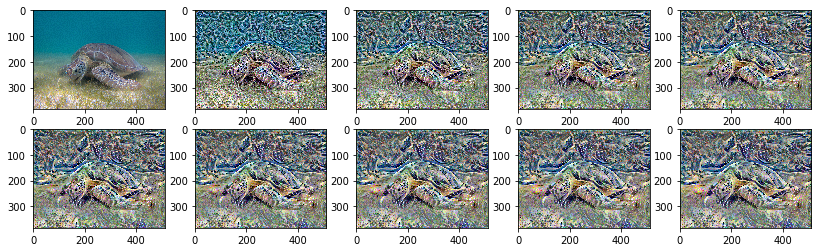

In [16]:
melhor_imagem, melhor_custo = style_transfer(diretorio_img_conteudo, diretorio_img_estilo, num_iteracoes=1000)

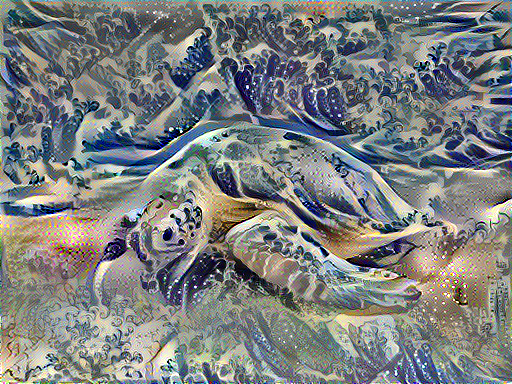

In [17]:
Image.fromarray(melhor_imagem) # usando a função Image do Pillow para imprimir na tela a melhor imagem

In [18]:
def mostra_resultados(melhor_imagem, diretorio_img_conteudo, diretorio_img_estilo):
    
    plt.figure(figsize=(10, 5)) # definindo o tamanho da figura para mostrar imagens de conteúdo e estilo
    img_conteudo = carrega_imagem(diretorio_img_conteudo)  # carregando a imagem de conteúdo
    img_estilo = carrega_imagem(diretorio_img_estilo) # carregando a imagem de estilo

    # Criando as regiões de plot para mostrar as imagens de conteúdo, estilo e imagem gerada
    plt.subplot(1, 2, 1)
    mostra_imagem(img_conteudo, 'Imagem de conteúdo')

    plt.subplot(1, 2, 2)
    mostra_imagem(img_estilo, 'Imagem de estilo')

    plt.figure(figsize=(10, 10))
    plt.imshow(melhor_imagem)
    plt.title('Imagem misturada')
    plt.show()

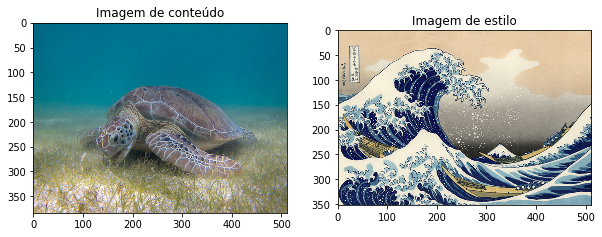

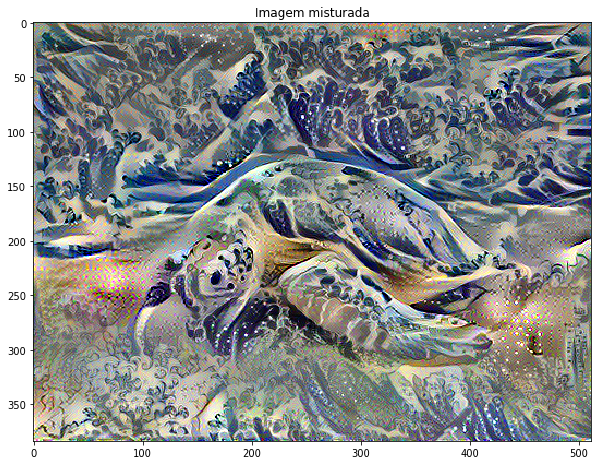

In [19]:
mostra_resultados(melhor_imagem, diretorio_img_conteudo, diretorio_img_estilo)